In [22]:
import pandas as pd 
import numpy as np
df = pd.read_excel("./data/spy_data.xlsx", sheet_name = 'total returns')
df = df.set_index('date')
df['Excess_SPY'] = df['SPY'] - df['^IRX']
df

,SPY,^IRX,Excess_SPY
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841
...,...,...,...
2024-07-29,0.000588,0.000204,0.000384
2024-07-30,-0.005066,0.000204,-0.005270
2024-07-31,0.016255,0.000204,0.016051


In [76]:
start = '2000-12-29'
quantile = 0.05
window = 2
expanding_sample = df.loc[(df.index >= start)]['Excess_SPY']
expanding = expanding_sample.expanding(60).quantile(quantile)
data = pd.DataFrame(expanding_sample)
data['expanding_sample'] = expanding
data

,Excess_SPY,expanding_sample
date,,
2000-12-29,-0.019157,NaN
2001-01-02,-0.018329,NaN
2001-01-03,0.047815,NaN
2001-01-04,-0.010972,NaN
2001-01-05,-0.032840,NaN
...,...,...
2024-07-29,0.000384,-0.018775
2024-07-30,-0.005270,-0.018775
2024-07-31,0.016051,-0.018774


<Axes: xlabel='date'>

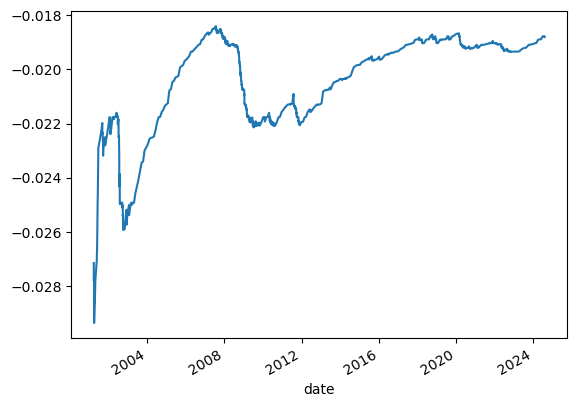

In [78]:
expanding.plot()

In [82]:
data['difference'] = np.where(data['expanding_sample'] > data['Excess_SPY'], 1, 0)
data['difference'].value_counts()

difference
0    5698
1     230
Name: count, dtype: int64

In [86]:
(data['difference'].sum()/len(data))*100

3.8798920377867745

<Axes: xlabel='date'>

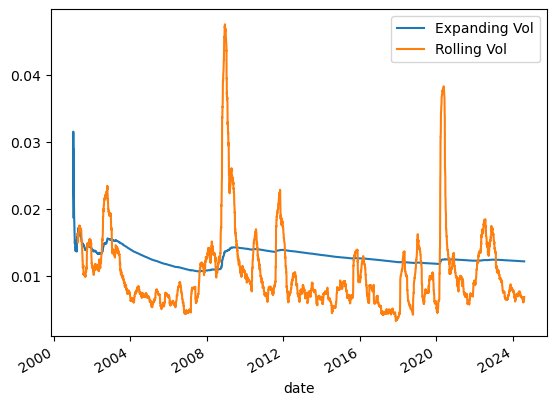

In [108]:
m = 252

def calc_vol(returns: pd.DataFrame): 

    expanding_vol = np.sqrt((returns**2).expanding(window).mean().shift())
    rolling_vol = np.sqrt((returns**2).rolling(60).mean().shift())

    vol_df = pd.DataFrame({
        'Expanding Vol': expanding_vol, 
        'Rolling Vol': rolling_vol
    })
    return vol_df

vol_df = calc_vol(data['Excess_SPY'])

vol_df.plot()



/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_6791/2234645140.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00015873015873015873' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ewma.iloc[0] = sigma_0**2  # Start with the variance


<Axes: xlabel='date'>

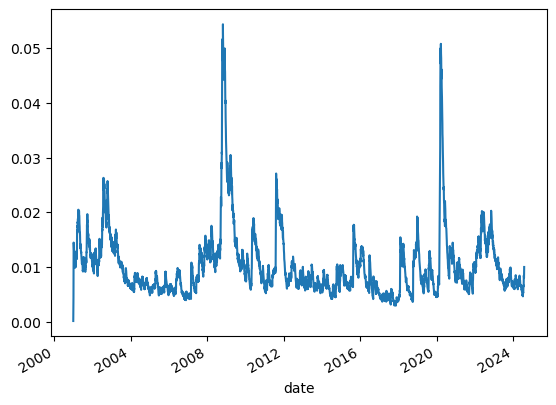

In [140]:
theta = 0.94 
sigma_0 = 0.20 / np.sqrt(m)  # Assuming m is defined earlier

avail_dates = data.index
ewma = pd.Series(0, index=avail_dates, name='EWMA')
ewma.iloc[0] = sigma_0**2  # Start with the variance

for i, j in enumerate(avail_dates[1:], 1):
    ewma.iloc[i] = np.sqrt(ewma.iloc[i-1]**2 * theta + (1-theta) * data['Excess_SPY'].loc[j]**2)

ewma.plot()
